In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import data_files

# Fair Dice Test

Roll each die, separately, 100 times on a flat surface.
Any rolls where the die hit another object were thrown out.

In [2]:
rolls = data_files.read_tsv('dice_rolls.tsv')

In [3]:
roll_counts = pd.DataFrame({
    "Green": rolls["Green"].value_counts().sort_index(),
    "Blue": rolls["Blue"].value_counts().sort_index()
})

In [4]:
def expected_occurrences_per(n):
    return math.ceil(1 / 6 * n)

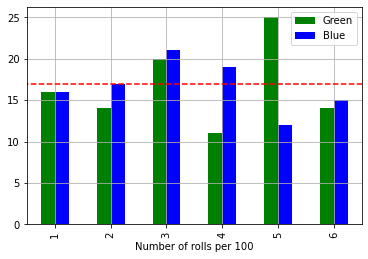

In [5]:
roll_counts.plot.bar(color=roll_counts.columns)
plt.xlabel("Number of rolls per 100")

# -1 is a hack to avoid having to re-index
xs = np.arange(-1, 7)
ys = [expected_occurrences_per(100)] * len(xs)
plt.plot(xs, ys, '--r')

plt.grid()